### Web Scraping
- Task: Scrape news articles or blog posts from a website of your choice. Ensure you choose a site that allows scraping and has a substantial amount of text content (e.g., news portal, blog site).
- Goal: Collect at least 100 articles/posts on a specific theme or topic (e.g., technology, health, politics). The content should be varied enough to allow for interesting NER, sentiment analysis, and topic modeling results.

In [184]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt

In [140]:
def bsoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

In [172]:
url = "https://time.com/section/health/?page="

all_headlines = []
all_elements = []

titles = []
articles = []

# Loop through each page
for page in range(1,11):   
    soup = bsoup(url+str(page))
    all_headlines.append(soup.find('body').find_all('h2'))
    all_elements.append(soup.find_all('div', class_='taxonomy-tout'))

# Title
for headlines in all_headlines:
    for x in headlines:
        titles.append(x.text.strip())

# Article
for elements in all_elements:
    for e in elements:
        a_element = e.find('a')
        if a_element and 'href' in a_element.attrs:
            url = 'https://time.com' + a_element['href']
            soup = bsoup(url)

            text = soup.find("div", {"id":"article-body-main"}).text
            articles.append(text)

In [173]:
len(articles)

200

In [174]:
df = pd.DataFrame({'title':titles, 'article':articles})
df

,title,article
0,Cameroon Starts World-First Malaria Vaccine Pr...,Cameroon will be the first country to routinel...
1,Charcuterie Is Linked to Salmonella,Federal health officials are expanding a warni...
2,Multivitamins May Slow Brain Aging,"Aging is inevitable, but that doesn’t stop us ..."
3,How Pigs Could Help People Who Need Liver Tran...,"Organ transplants save lives, but healthy spec..."
4,Complementary Treatments for Lupus,Being diagnosed with a chronic illness can be ...
...,...,...
195,Reframing How We Think About Overdose Deaths,I’ve been living in recovery from opioid use d...
196,Why You Should Reframe Your Life As a Hero's J...,You might not think you have much in common wi...
197,People Are Getting Health Tests for Fun,Convincing Americans to get their recommended ...
198,The Myths About Aging Make Aging Worse,"If you’re alive today, there’s a good chance y..."


### Named Entity Recognition
- Task: Utilize an NLP library like spaCy or NLTK to perform NER on the collected text. Identify and categorize all named entities (e.g., persons, organizations, locations).
- Goal: Understand the distribution of named entities in your dataset and how they relate to the content's topic or sentiment.

In [180]:
nlp = spacy.load('en_core_web_sm')
nlp_articles = []
for article in articles:
    nlp_articles.append(nlp(article))

In [183]:
# Count # of times each entity label appears
label_counter = Counter(ent.label_ for article in nlp_articles for ent in article.ents)
sorted_label_count_pairs = label_counter.most_common()

print("Total # of Entity Labels:", len(sorted_label_count_pairs))
print("Total Sum of Entity Label Counts:", sum(count for label, count in sorted_label_count_pairs))

for label, count in sorted_label_count_pairs:
    print(f"{label}: {count}")

Total # of Entity Labels: 18
Total Sum of Entity Label Counts: 12694
ORG: 3239
DATE: 2493
PERSON: 2216
CARDINAL: 1569
GPE: 1308
NORP: 400
PERCENT: 394
ORDINAL: 342
TIME: 208
MONEY: 135
LOC: 127
WORK_OF_ART: 69
PRODUCT: 57
QUANTITY: 57
FAC: 29
LAW: 27
EVENT: 20
LANGUAGE: 4


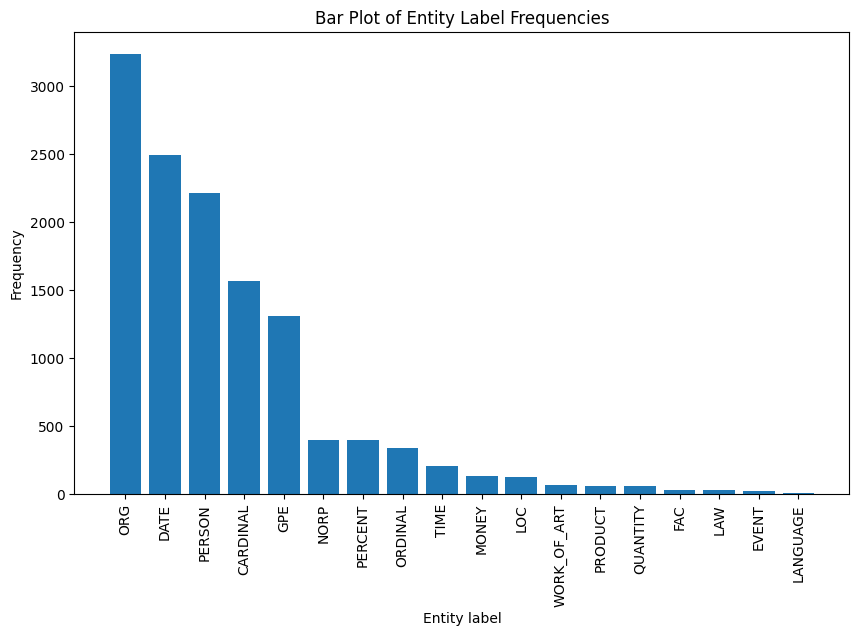

In [185]:
labels, frequencies = zip(*sorted_label_count_pairs)

plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies)
plt.xticks(labels, rotation=90)
plt.xlabel('Entity label')
plt.ylabel('Frequency')
plt.title("Bar Plot of Entity Label Frequencies")
plt.show()

In [206]:
common_org = Counter()
common_per = Counter()

for article in nlp_articles:
    org_list = set([ent.lemma_.lower() for ent in article.ents if ent.label_ == u"ORG"])
    per_list = set([ent.lemma_.lower() for ent in article.ents if ent.label_ == u"PERSON"])
    
    common_org.update(org_list)
    common_per.update(per_list)

print("Total # of Org Labels:", len(common_org.items()))
#print("Total Sum of Org Label Counts:", sum(count for label, count in common_org.items()))
print('Most frequently occurring organizations:')
print("\n".join(["  %s: %d" % (entity, count) for entity, count in common_org.most_common(10)]))

print()

print("Total # of Person Labels:", len(common_per.items()))
print('Most frequently occurring persons:')
print("\n".join(["  %s: %d" % (entity, count) for entity, count in common_per.most_common(10)]))

Total # of Org Labels: 1310
Most frequently occurring organizations:
  covid-19: 69
  fda: 40
  cdc: 31
  the u.s. food and drug administration: 28
  the u.s. centers for disease control and prevention: 24
  time: 18
  rsv: 16
  the world health organization: 15
  the centers for disease control and prevention: 14
  harvard medical school: 13

Total # of Person Labels: 1173
Most frequently occurring persons:
  covid-19: 32
  pfizer: 9
  paxlovid: 7
  moderna: 6
  crispr: 5
  covid: 5
  biden: 5
  safe: 5
  wegovy: 5
  smith: 4


### Sentiment Analysis
- Task: Perform sentiment analysis on each article or post using any standard sentiment analysis tool or library (e.g., TextBlob, VADER, custom model).
- Goal: Determine the overall sentiment distribution across your corpus. Is the sentiment predominantly positive, negative, or neutral? How does sentiment relate to the topics discovered in the next step?

### Sentiment Analysis
- Task: Perform sentiment analysis on each article or post using any standard sentiment analysis tool or library (e.g., TextBlob, VADER, custom model).
- Goal: Determine the overall sentiment distribution across your corpus. Is the sentiment predominantly positive, negative, or neutral? How does sentiment relate to the topics discovered in the next step?

In [215]:
import nltk
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

In [220]:
sent_pol = []
sent_class = []
vader_scores = []
vader_class = []
sid = SentimentIntensityAnalyzer()

for article in articles:
    blob = TextBlob(article)
    
    # Get the sentiment polarity (-1 to 1)
    sentiment_polarity = blob.sentiment.polarity
    vader_score = sid.polarity_scores(article)

    sent_pol.append(sentiment_polarity)
    sent_class.append('Positive' if sentiment_polarity > 0 else 'Negative' if sentiment_polarity < 0 else 'Neutral')

    vader_scores.append(vader_score['compound'])
    vader_class.append('Positive' if vader_score['compound'] > 0 else 'Negative' if vader_score['compound'] < 0 else 'Neutral')

df['sentiment_polarity'] = sent_pol
df['sentiment_class'] = sent_class
df['vader_score'] = vader_scores
df['vader_class'] = vader_class

,title,article,sentiment_polarity,sentiment_class,vader_score,vader_class
0,Cameroon Starts World-First Malaria Vaccine Pr...,Cameroon will be the first country to routinel...,0.131687,Positive,0.9724,Positive
1,Charcuterie Is Linked to Salmonella,Federal health officials are expanding a warni...,0.001389,Positive,-0.9636,Negative
2,Multivitamins May Slow Brain Aging,"Aging is inevitable, but that doesn’t stop us ...",0.174318,Positive,0.9974,Positive
3,How Pigs Could Help People Who Need Liver Tran...,"Organ transplants save lives, but healthy spec...",0.143841,Positive,0.9678,Positive
4,Complementary Treatments for Lupus,Being diagnosed with a chronic illness can be ...,0.181655,Positive,0.9995,Positive
...,...,...,...,...,...,...
195,Reframing How We Think About Overdose Deaths,I’ve been living in recovery from opioid use d...,0.078776,Positive,-0.9990,Negative
196,Why You Should Reframe Your Life As a Hero's J...,You might not think you have much in common wi...,0.126125,Positive,0.9995,Positive
197,People Are Getting Health Tests for Fun,Convincing Americans to get their recommended ...,0.057546,Positive,0.9960,Positive
198,The Myths About Aging Make Aging Worse,"If you’re alive today, there’s a good chance y...",0.131692,Positive,0.9975,Positive


In [221]:
df[:50]

,title,article,sentiment_polarity,sentiment_class,vader_score,vader_class
0,Cameroon Starts World-First Malaria Vaccine Pr...,Cameroon will be the first country to routinel...,0.131687,Positive,0.9724,Positive
1,Charcuterie Is Linked to Salmonella,Federal health officials are expanding a warni...,0.001389,Positive,-0.9636,Negative
2,Multivitamins May Slow Brain Aging,"Aging is inevitable, but that doesn’t stop us ...",0.174318,Positive,0.9974,Positive
3,How Pigs Could Help People Who Need Liver Tran...,"Organ transplants save lives, but healthy spec...",0.143841,Positive,0.9678,Positive
4,Complementary Treatments for Lupus,Being diagnosed with a chronic illness can be ...,0.181655,Positive,0.9995,Positive
5,How Long Does It Take to Get COVID-19?,With COVID-19 spreading as widely as it is rig...,0.003473,Positive,-0.6976,Negative
6,Hong Kong No Longer Has World’s Longest Life E...,Hong Kong residents no longer have the world’s...,0.065679,Positive,-0.9688,Negative
7,How to Scale Back on Social Media,Emma Lembke joined Instagram when she was 12. ...,0.088674,Positive,0.9944,Positive
8,Is It Time for a Surgeon General Report on Vap...,"NEW YORK — Sixty years ago, the U.S. surgeon g...",0.091275,Positive,-0.9545,Negative
9,Drugs like Ozempic and Wegovy Show No Link to ...,A preliminary review of side effects from popu...,0.153125,Positive,-0.7964,Negative


### Topic Modeling
- Task: Implement a topic modeling technique (e.g., LDA, NMF) to discover the underlying topics in your corpus. You may use libraries like Gensim or scikit-learn.
- Goal: Identify the main topics and their distribution across your dataset. How do these topics correlate with the named entities and sentiments found?

In [252]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

X = df['article']
vocab_size = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                min_df=2,
                                stop_words='english',
                                max_features=vocab_size)
                                
X_tfidf = tfidf_vectorizer.fit_transform(X)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_tfidf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [253]:
num_top_words = 10
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()

    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(len(topic_word_distributions)):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tfidf_vectorizer)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
vaping : 0.008240679054857826
juul : 0.007928850825627384
dengue : 0.005648182425908013
cigarettes : 0.0010003648137843902
tobacco : 0.0009911805457917904
series : 0.0009905577949569438
book : 0.0009900620029254987
story : 0.0009893468483723857
big : 0.0009870202581103292
couple : 0.0009869815941152074

[Topic 1]
caviar : 0.00721727424779214
allowed : 0.000996754155237796
market : 0.0009967513137896556
quite : 0.0009965382700081534
tested : 0.0009965319086462944
sold : 0.0009962685937154475
ensure : 0.0009962416063324742
demand : 0.000996182459689872
samples : 0.0009961341498041828
considered : 0.000995921470841429

[Topic 2]
dengue : 0.0010004465406226598
caviar : 0.0010002488751867573
vaping : 0.0010002133296497591
racism : 0.0010001668834171162
hearing : 0.0010001529763416298
liver : 0.0010001252165425455
bugs : 0.0010001121493568596
pig : 0.0010001007381814906
dry : 0.0010000931207203817
sp

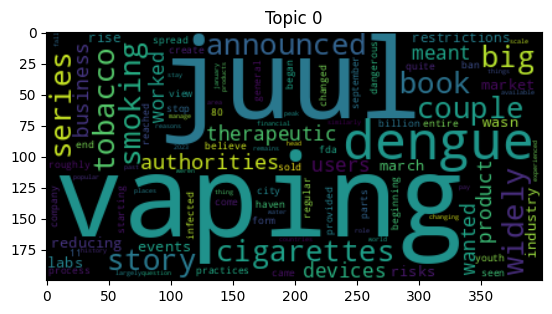

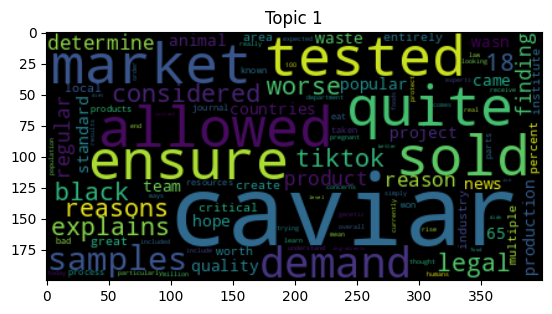

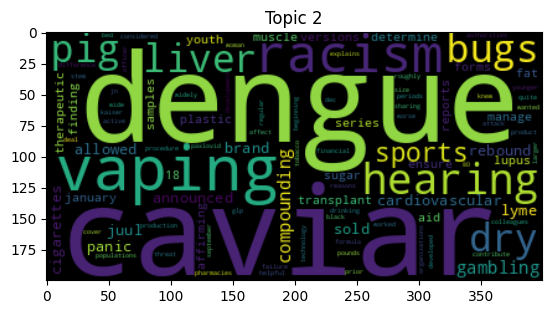

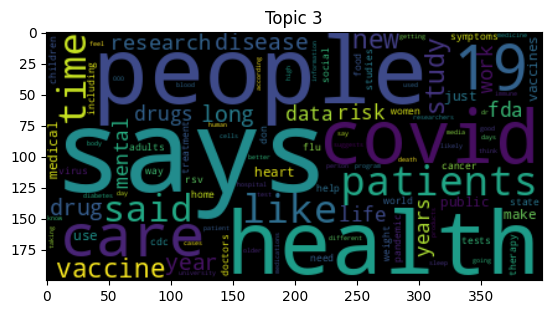

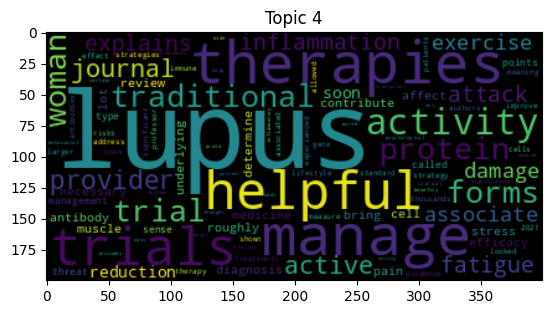

In [254]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tfidf_vectorizer.get_feature_names_out()
num_topics = len(topic_word_distributions)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

In [261]:
from gensim.models import LdaModel

# Remove rare and common tokens.
from gensim.corpora import Dictionary
dictionary = Dictionary(df['article'])
dictionary.filter_extremes(no_below=20, no_above=0.5)

id2word = dictionary.id2token
model = LdaModel(corpus=X_tfidf,
                id2word=id2word,
                num_topics=5, 
                random_state=0,
                chunksize=2000,
                passes=20,
                per_word_topics=True)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string